# Import Libraries Needed

In [1]:
import torch
from torch import nn
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from torch.optim import Optimizer
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
import pandas as pd
from tqdm import tqdm

# Question (i): Implementing Adam (with l2 regularization) and AdamW

*Hint: you may have to use np.add to add two numpy arrays to avoid getting an error message*

In [2]:
# Implement the Adam with L2 optimization algorithm from scratch using numpy and torch's optimizer class
class AdamScratch(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdamScratch, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for w in group['params']:
                if w.grad is None:
                    continue
                grad = w.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[w]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['m'] = np.zeros_like(w.data)
                    # Exponential moving average of squared gradient values
                    state['v'] = np.zeros_like(w.data)

                m, v = state['m'], state['v']
                beta1, beta2 = group['betas']

####################################  YOUR CODE HERE  ####################################
                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(w.data, alpha=group['weight_decay'])

                # Decay the first and second moment running average coefficient
                m = np.add(beta1 * m, (1 - beta1) * grad)
                v = np.add(beta2 * v, (1 - beta2) * grad * grad)

                m_hat = m / (1 - beta1 ** state['step'])
                v_hat = v / (1 - beta2 ** state['step'])
                w.data = w.data - group['lr'] * m_hat / (np.sqrt(v_hat) + group['eps'])
##########################################################################################

        return loss

#Now we implement AdamW using numpy and torch's optimizer class
class AdamWScratch(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdamWScratch, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for w in group['params']:
                if w.grad is None:
                    continue
                grad = w.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[w]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['m'] = np.zeros_like(w.data)
                    # Exponential moving average of squared gradient values
                    state['v'] = np.zeros_like(w.data)
                
                m, v = state['m'], state['v']
                beta1, beta2 = group['betas']

####################################  YOUR CODE HERE  ####################################
                state['step'] += 1

                m = np.add(beta1 * m, (1 - beta1) * grad)
                v = np.add(beta2 * v, (1 - beta2) * grad * grad)

                m_hat = m / (1 - beta1 ** state['step'])
                v_hat = v / (1 - beta2 ** state['step'])

                w.data = w.data - group['lr'] * (m_hat / (np.sqrt(v_hat) + group['eps']) + group['weight_decay'] * w.data)
##########################################################################################

        return loss

# Visualizing the Dataset

We will test l2 regularized Adam and AdamW on a synthetically generated classification task. Run the cell below to visualize the dataset. Increasing the `noise` and `spirals` parameters will lead to a more difficult dataset.

Source: https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5

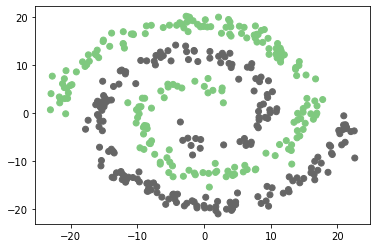

In [3]:
def make_spiral(N=200, noise=1, seed=0, spirals=1.5):
  '''
  N = number of sample points generated
  noise = noise added to both coodirates of all sample points
  half_turns = number full spirals that each color makes
  '''
  np.random.seed(seed)
  theta = np.sqrt(np.random.rand(N))*spirals*2*pi # np.linspace(0,2*pi,100)

  r_a = 2*theta + pi
  data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
  x_a = data_a + noise * np.random.randn(N,2)

  r_b = -2*theta - pi
  data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
  x_b = data_b + noise * np.random.randn(N,2)

  res_a = np.append(x_a, np.zeros((N,1)), axis=1)
  res_b = np.append(x_b, np.ones((N,1)), axis=1)

  res = np.append(res_a, res_b, axis=0)
  np.random.shuffle(res)
  x = res[:, :2]
  y = res[:, 2:]
  return x, y

x, y = make_spiral(N=200, noise=1, spirals=1.5)
plt.scatter(*x.T, c=y, cmap=plt.cm.Accent)
plt.show()

# Defining classification model architecture and the simulation training loop. 
Feel free to change the network architecture after completing all tasks to further the differences between the two algorithms on a simpler or more complex network. Only do this **after** you have verified your implementations of Adam(W) is correct.

In [4]:
class MoonNet(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=8):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [5]:
def simulate(optimizer_init, lr, wd, n=100, trials=5, noise=1, n_iter=100 ,seed=None, spirals=1.5): 
  losses_average = [0 for i in range(n_iter)]
  accuracy_average = [0 for i in range(n_iter)]
  iterations = [i for i in range(1, n_iter+1)]

  for trial in range(trials): 
    ###CHANGE HERE TO MODIFY THE WAY TRAIN/VAL DATA IS GENERATED
    data_seed = seed if seed is not None else 0
    x, y = make_spiral(N=n, noise=noise, seed=data_seed+trial, spirals=spirals)
    x_val, y_val = make_spiral(N=n, noise=noise, seed=data_seed+trial, spirals=spirals)
    y = np.reshape(y, (len(y), 1))
    y_val = np.reshape(y_val, (len(y_val), 1))

    x = torch.tensor(x, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    x_val = torch.tensor(x_val, dtype=torch.float)
    y_val = torch.tensor(y_val, dtype=torch.float)

    loss_fn = nn.BCELoss()

    if seed is not None:
      torch.manual_seed(seed*trial+trial)
    model = MoonNet()
    optimizer = optimizer_init(model.parameters(), lr=lr, weight_decay=wd)

    # Run training
    for i in range(0, n_iter):
      optimizer.zero_grad()
      predictions = model(x)
      loss = loss_fn(predictions, y)
      loss.backward()
      optimizer.step()

      val_predictions = model(x_val)
      val_loss = loss_fn(val_predictions, y_val)
      losses_average[i] += val_loss.detach().numpy()
    
    accuracy = torch.sum((1*(val_predictions > 0.5) == y_val)).item() / len(y_val)
    accuracy_average.append(accuracy)

  for i in range(0, n_iter):
    losses_average[i] = losses_average[i]/trials
  accuracy_average = sum(accuracy_average) / trials
  
  return iterations, losses_average, accuracy_average

# Running the Tests

As a first sanity check, let's train two models to perform the classification task. Both models should achieve at least 99% accuracy.


[]

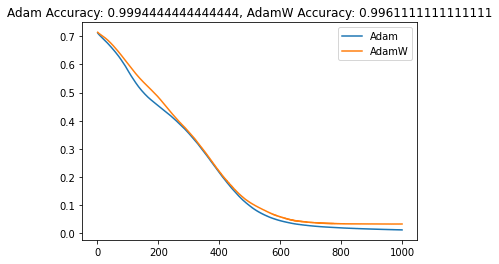

In [6]:
lr = 0.001
wd = 0.001
n_iter = 1000

iterations, losses_average, torch_accuracy_average = simulate(optimizer_init=AdamScratch, lr=lr, wd=wd, n=300, trials=3, noise=0.2, n_iter=n_iter, spirals=1)
iterations, w_losses_average, accuracy_average = simulate(optimizer_init=AdamWScratch, lr=lr, wd=wd, n=300, trials=3, noise=0.2, n_iter=n_iter, spirals=1)
plt.plot(iterations, w_losses_average, label='Adam')
plt.plot(iterations, losses_average, label='AdamW')
plt.title('Adam Accuracy: ' + str(accuracy_average) + ', AdamW Accuracy: ' + str(torch_accuracy_average))
plt.legend()
plt.plot()

Run the code below to check your implementation of Adam  and AdamW. The code below should run without errors and give a difference in loss of 0 or extremely close to 0.

In [8]:
# Code for creating expected outputs for autograder
_, expected_losses_adam, _ = simulate(optimizer_init=AdamScratch, lr=0.1, wd=1e-1, n=100, trials=10, noise=0.1, seed=0)
_, expected_losses_adamW, _ = simulate(optimizer_init=AdamWScratch, lr=0.1, wd=1e-1, n=100, trials=10, noise=0.1, seed=0)
df = pd.DataFrame({"Adam" : expected_losses_adam, "AdamW" : expected_losses_adamW})
df.to_csv("expected_losses.csv")

In [9]:
# CODE FOR AUTOGRADING IMPLEMENTATION
expected = pd.read_csv("expected_losses.csv")
expected_losses_adam = expected['Adam']
expected_losses_adamW = expected['AdamW']
_, implementation_losses_adam, _ = simulate(optimizer_init=AdamScratch, lr=0.1, wd=1e-1, n=100, trials=10, noise=0.1, seed=0)
_, implementation_losses_adamW, _ = simulate(optimizer_init=AdamWScratch, lr=0.1, wd=1e-1, n=100, trials=10, noise=0.1, seed=0)

In [10]:
adam_diff = abs(expected_losses_adam.tolist()[-1] - implementation_losses_adam[-1])
adamW_diff = abs(expected_losses_adamW.tolist()[-1] - implementation_losses_adamW[-1])
print("The difference in loss of the Adam implementation : "  + str(adam_diff))
print("The difference in loss of the AdamW implementation : "  + str(adamW_diff))

adam_all_diff = np.sum(np.abs(np.array(expected_losses_adam.tolist()) - np.array(implementation_losses_adam)))
adamW_all_diff = np.sum(np.abs(np.array(expected_losses_adamW.tolist()) - np.array(implementation_losses_adamW)))
print("The difference in loss over all train steps of Adam : " + str(adam_all_diff))
print("The difference in loss over all train steps of AdamW : " + str(adamW_all_diff))

The difference in loss of the Adam implementation : 0.0
The difference in loss of the AdamW implementation : 0.0
The difference in loss over all train steps of Adam : 0.0
The difference in loss over all train steps of AdamW : 0.0


# Question (ii): Visualizing Hyperparameter Space
After running the initial settings, adjust the difficulty of the dataset. The dataset becomes "easier" with more samples and lower noise, and the dataset becomes "harder" with a larger number of spirals. For a lower variance of model performances, increase number of trials per simulation. Do be wary that this linearly increases the amount of time to run these cells.
Additionally, feel free to adjust the learning rate and weight decay values in order to zoom in or shift around the view of the heatmap. 

In [ ]:
n = 300 # number of training/validation samples to generate
noise = 0.5 # noise level of training/validation data
spirals = 1 # number of times spiral data coils around the origin
trials = 1 # number of trials to run per simulation
n_iter = 200 # number of iterations to train classifier for 

# These are the hyperparameters that we will search over and visualize heatmaps of model performances
lr_params = [0.1 * (0.65)**k for k in range(16)]
wd_params = [0.1 * (0.4)**k for k in range(24)]
lr_params_w = [0.1 * (0.65)**k for k in range(16)]
wd_params_w = [0.1 * (0.4)**k for k in range(24)]

In [ ]:
param_search = np.zeros((len(lr_params), len(wd_params)))
param_search_loss = np.zeros((len(lr_params), len(wd_params)))
for i, lr in enumerate(tqdm(lr_params)):
  for j, wd in enumerate(wd_params):
    iterations, losses_average, accuracy_average = simulate(optimizer_init=AdamScratch, lr=lr, wd=wd, n=n, trials=trials, noise=noise, n_iter=n_iter, spirals=spirals)
    param_search[i, j] = accuracy_average
    param_search_loss[i, j] = losses_average[-1]
    # print(f'lr = {lr}, wd = {wd}: {accuracy_average}')
np.save('param_search.npy', param_search)
np.save('param_search_loss.npy', param_search_loss)

100%|██████████| 16/16 [02:27<00:00,  9.23s/it]


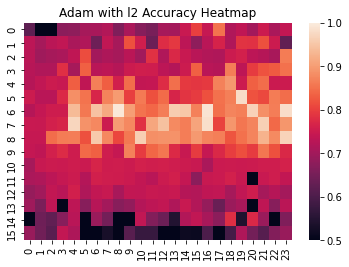

In [ ]:
param_search = np.load('param_search.npy')
ax = sns.heatmap(param_search, vmin=0.5, vmax=1)
plt.title( 'Adam with l2 Accuracy Heatmap' )
plt.show()

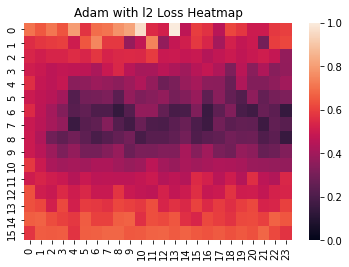

In [ ]:
param_search_loss = np.load('param_search_loss.npy')
ax = sns.heatmap(param_search_loss, vmin=0, vmax=1)
plt.title( 'Adam with l2 Loss Heatmap')
plt.show()

In [ ]:
w_param_search = np.zeros((len(lr_params_w), len(wd_params_w)))
w_param_search_loss = np.zeros((len(lr_params_w), len(wd_params_w)))
for i, lr in enumerate(tqdm(lr_params_w)):
  for j, wd in enumerate(wd_params_w):
    iterations, losses_average, accuracy_average = simulate(optimizer_init=AdamWScratch, lr=lr, wd=wd, n=n, trials=trials, noise=noise, n_iter=n_iter, spirals=spirals)
    w_param_search[i, j] = accuracy_average
    w_param_search_loss[i, j] = losses_average[-1]
    # print(f'lr = {lr}, wd = {wd}: {accuracy_average}')
np.save('w_param_search.npy', w_param_search)
np.save('w_param_search_loss.npy', w_param_search_loss)

100%|██████████| 16/16 [02:25<00:00,  9.12s/it]


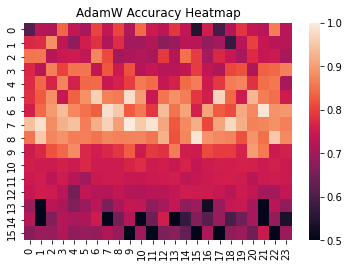

In [ ]:
w_param_search = np.load('w_param_search.npy')
ax = sns.heatmap(w_param_search, vmin=0.5, vmax=1)
plt.title('AdamW Accuracy Heatmap')
plt.show()

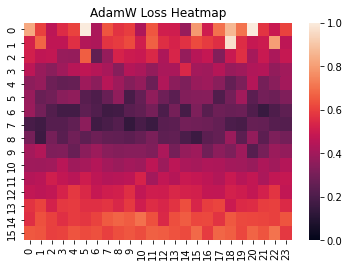

In [ ]:
w_param_search_loss = np.load('w_param_search_loss.npy')
ax = sns.heatmap(w_param_search_loss, vmin=0, vmax=1)
plt.title('AdamW Loss Heatmap')
plt.show()

In [ ]:
param_search = np.array(np.load('param_search.npy'))
param_search_loss = np.array(np.load('param_search_loss.npy'))
w_param_search = np.array(np.load('w_param_search.npy'))
w_param_search_loss = np.array(np.load('w_param_search_loss.npy'))

threshhold = 0.9
print(f"Number of runs over {threshhold*100}% on Adam:", np.sum(param_search > threshhold))
print(f"Number of runs over {threshhold*100}% on AdamW:", np.sum(w_param_search > threshhold))
print(f"Best run of Adam:", np.max(param_search))
print(f"Best run of AdamW:", np.max(w_param_search))

Number of runs over 90.0% on Adam: 21
Number of runs over 90.0% on AdamW: 31
Best run of Adam: 0.995
Best run of AdamW: 0.9983333333333333
